# Settings, imports

In [1]:
import pandas as pd

from google.cloud import language_v1
from google.oauth2 import service_account

import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import spacy

In [5]:
from wordcloud import WordCloud

In [6]:
from collections import Counter 

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [8]:
#MODELING

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from xgboost import XGBRegressor

In [11]:
from sklearn.metrics import mean_absolute_error

In [12]:
from xgboost import plot_importance

In [13]:
from sklearn.linear_model import LassoCV

In [14]:
from scipy import stats
from scipy.special import inv_boxcox

# Funkce

In [15]:
def mazani_rovnase(df, zceho, co):
    index_mazani = df[df[zceho] == co].index
    print(len(index_mazani))
    dataset.drop(index_mazani , inplace=True)
    
def mazani_nerovnase(df, zceho, co):
    index_mazani = df[df[zceho] != co].index
    print(len(index_mazani))
    dataset.drop(index_mazani , inplace=True)
    
def mazani_vetsi(df, zceho, co):
    index_mazani = df[df[zceho] > co].index
    print(len(index_mazani))
    dataset.drop(index_mazani , inplace=True)
    
def mazani_mensi(df, zceho, co):
    index_mazani = df[df[zceho] < co].index
    print(len(index_mazani))
    dataset.drop(index_mazani , inplace=True)

def mazani_str_contains(df, zceho, co):
    index_mazani = df[df[zceho].str.contains(co, regex=False)].index
    print(len(index_mazani))
    dataset.drop(index_mazani , inplace=True)

In [16]:
def vyplotit(df, co):
    sns.distplot(df[co]);
    fig = plt.figure()

# Load data

In [17]:
# read data
dataset = pd.read_csv("Hotel_Reviews.csv")

# Úpravy datasetu

In [18]:
#podíváme se na první 3 řádky
dataset.head(3)

Hotel_Address  Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name Reviewer_Nationality                                    Negative_Review  Review_Total_Negative_Word_Counts  Total_Number_of_Reviews                                    Positive_Review  Review_Total_Positive_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score                                               Tags days_since_review        lat       lng
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...                           194    8/3/2017            7.7  Hotel Arena              Russia    I am so angry that i made this post available...                                397                     1403   Only the park outside of the hotel was beauti...                                 11                                           7             2.9  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days  52.360576  4.915968
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...                           194    8/3/2017            7.7  Hotel Arena             Ireland                                         No Negative                                  0                     1403   No real complaints the hotel was great great ...                                105                                           7             7.5  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days  52.360576  4.915968
2   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...                           194   7/31/2017            7.7  Hotel Arena           Australia    Rooms are nice but for elderly a bit difficul...                                 42                     1403   Location was good and staff were ok It is cut...                                 21                                           9             7.1  [' Leisure trip ', ' Family with young childre...            3 days  52.360576  4.915968

In [19]:
len(dataset)

515738

## Reviewer Nacionality

<AxesSubplot:xlabel='Reviewer_Nationality', ylabel='count'>

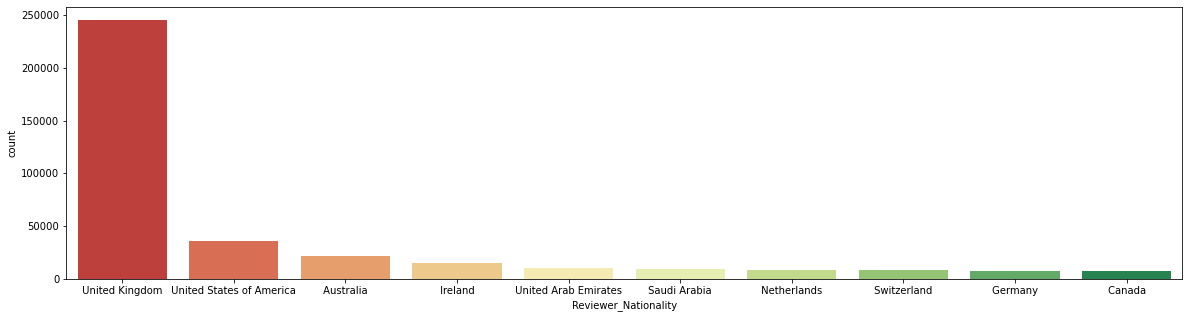

In [20]:
#Odkud jsou rewiews? (Top 10 zemi)
plt.rcParams['figure.figsize'] = (20.0, 5.0)
sns.countplot(x='Reviewer_Nationality', data=dataset, palette="RdYlGn",order=dataset.Reviewer_Nationality.value_counts().iloc[:10].index)

In [21]:
#Protože chceme spočítat sentiment u všech komentářů, musím si vybrat určitou frakci dat.
#Pro náš business účel jsme si vybrali pouze ČR, abychom udělali doporučení pro českou klientelu.

### Jen Česká republika

In [22]:
len(dataset)

515738

In [23]:
dataset = dataset[dataset.Reviewer_Nationality.str.contains('Czech Republic')]

In [24]:
dataset.reset_index(inplace=True,drop=True)

In [25]:
len(dataset)

2311

## smazani No Negative, No Positive

In [26]:
# Pokud data neměla review v jedné ze dvou sloupcích review, input byl "No Negative" a "No Positive"
# Pro účely sentimentu musíme hodnoty smazat

In [27]:
index_neg = dataset[dataset['Negative_Review'] == 'No Negative'].index

In [28]:
dataset['No_Negative'] = 0
dataset['No_Negative'].loc[index_neg] = 1

c:\users\vojte\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
dataset['Negative_Review'].loc[index_neg] = ''

In [30]:
index_pos = dataset[dataset['Positive_Review'] == 'No Positive'].index

In [31]:
dataset['No_Positive'] = 0
dataset['No_Positive'].loc[index_pos] = 1

In [32]:
dataset['Positive_Review'].loc[index_pos] = ''

## spojit negative and positive

In [33]:
dataset["review"] = dataset["Negative_Review"] + dataset["Positive_Review"]

# Sentiment - Google API

In [34]:
creds = service_account.Credentials.from_service_account_file('./credentials.json')

In [35]:
client = language_v1.LanguageServiceClient(credentials=creds)

In [36]:
#Test
language = "en"
type_ = language_v1.Document.Type.PLAIN_TEXT
encoding_type = language_v1.EncodingType.UTF8

document = {"content": 'shit', "type_": type_, "language": language}
response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})

In [37]:
score = response.document_sentiment.score
magnitude = response.document_sentiment.magnitude
print("Overall Sentiment: score of {} with magnitude of {}".format(score, magnitude))

Overall Sentiment: score of -0.800000011920929 with magnitude of 0.800000011920929


In [38]:
language = "en"
type_ = language_v1.Document.Type.PLAIN_TEXT
encoding_type = language_v1.EncodingType.UTF8
dataset['sentiment'] = 0
dataset['magnitude'] = 0

for i in range(len(dataset)):
    document = {"content": dataset['review'][i], "type_": type_, "language": language}
    response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    score = response.document_sentiment.score
    dataset.iloc[i, dataset.columns.get_loc('sentiment')] = score
    magnitude = response.document_sentiment.magnitude
    dataset.iloc[i, dataset.columns.get_loc('magnitude')] = magnitude

In [39]:
# Seřazení podle nejvyšší sentiment
dataset.sort_values("sentiment", ascending = False)[["review", "sentiment","Reviewer_Score"]].head(20)

review  sentiment  Reviewer_Score
0      Excellent base for short visits to London V g...        0.9             9.6
1033   Great hotel Our second stay Superior rooms ar...        0.9             9.6
1044   Staff was extremely helpful Rooms were cozy a...        0.9             9.2
1047   super friendly staff good breakfast location ...        0.9             9.5
1048   Staff on reception very profesional Excelent ...        0.9             9.6
1050                                  location is great        0.9             8.8
1055                    good Free Wifi perfect location        0.9             8.3
1061   Everything modern and new Very nice window vi...        0.9             8.8
1073   Difficulties with card authorization and long...        0.9             9.2
1079                                Great accomodation         0.9            10.0
1080    Very nice and clean room In centre of town K...        0.9            10.0
1083   fantastic huge shower very close to sea beach...        0.9             9.2
1084   Execellent location convenient parking friend...        0.9             9.2
1087   Very comfortable hotel great location in the ...        0.9            10.0
1091                IT was really wonderfull Exklusive         0.9             9.6
1098                Unique location very friendly staff        0.9            10.0
1100             location staff nice room god breakfast        0.9             9.2
1101   Old furniture no aircondition Great breakfast...        0.9             8.8
1102   Very convinient place just in the centre exce...        0.9            10.0
1108   Outdated furniture Excellent location rich br...        0.9             8.3

In [40]:
# Seřazení podle nejnižší sentiment
dataset.sort_values("sentiment", ascending = True)[["review", "sentiment","Reviewer_Score"]].head(20)

review  sentiment  Reviewer_Score
1732   food in the restaurant bar treating people li...       -0.9             7.9
736    Internet was really REALLY bad The staff and ...       -0.8             6.3
1275             Wi Fi not working very slow Pentastyle       -0.8            10.0
829    Weak english at reception desk problem with i...       -0.8             7.1
1842   The floor was dirty  A variety of teas and co...       -0.8             6.7
831    At night hard to sleep due to a loud rattle c...       -0.8             5.4
2013                breakfast poor quality of breakfast       -0.8             8.0
1926       Problem with parking Super and near of Duomo       -0.8             9.6
2112      walls are not much soundproof value for money       -0.8             9.6
855                          Friday my bed was not made       -0.8             6.3
858                    Terrible and disgusting wellnes        -0.8             7.5
1256   very uncomfortable mattress limited food sele...       -0.8             7.5
1876              There were some ants around the desk        -0.8             9.6
869    theres no microwave nothing to heat up your f...       -0.8             4.2
2021   old and scratched bath missing any equipment ...       -0.8             7.5
143    Upon my arrival I was given a room without wi...       -0.8             3.8
1653   Hotel staff was not helpful at all They could...       -0.8             8.3
1285   Too noisy air condition you can hear even the...       -0.8             8.3
113                The provided wi fi was awfully slow        -0.8             7.5
112    NO FRESH VEGETABLES AND PLAIN YOGHURT FOR BRE...       -0.8             5.8

In [41]:
# Seřazení podle nejnižších Reviewer Score
dataset.sort_values("Reviewer_Score", ascending = True)[["review", "sentiment","Reviewer_Score"]].head(20)

review  sentiment  Reviewer_Score
2031   When ordering I made a mistake in the date I ...       -0.7             2.5
491                             Un proffesional Nothing       -0.2             2.5
213    We liked how the hotel is presented on Bookin...       -0.6             2.5
2181                             staff was rude Nothing       -0.8             2.5
1684   failure to comply with of orders room ready u...       -0.7             2.5
610    I ve never seen so with absolutly arrogance T...       -0.8             2.5
2040   Very dirty hotel staff at the reception are r...       -0.6             2.9
1491   Location is very central at the tram crossing...       -0.8             2.9
1196   From Gas station i had better food than from ...       -0.6             2.9
88     We stayed two nights and on the Sunday night ...       -0.6             2.9
1964   8 euros per day parking fee non covered parki...       -0.7             2.9
762    No free wifi tiny rooms good location terribl...       -0.5             3.3
2113   This hotel can be everything but 4 star It re...       -0.7             3.3
1561   We left the room in the morning made some sig...       -0.2             3.3
1861   The most thing the staff of the hotel were ve...       -0.6             3.3
582    The unfriendly reception of the hotel very ru...       -0.5             3.3
1353   it was written that parking is for free hower...       -0.6             3.3
1287   The service was very poor cleanliness also no...       -0.7             3.3
219                                    quality of rooms        0.0             3.8
1807   This is not a 4 hotel because style equipment...       -0.4             3.8

# Vizualizace dat

# Sentiment propability plot

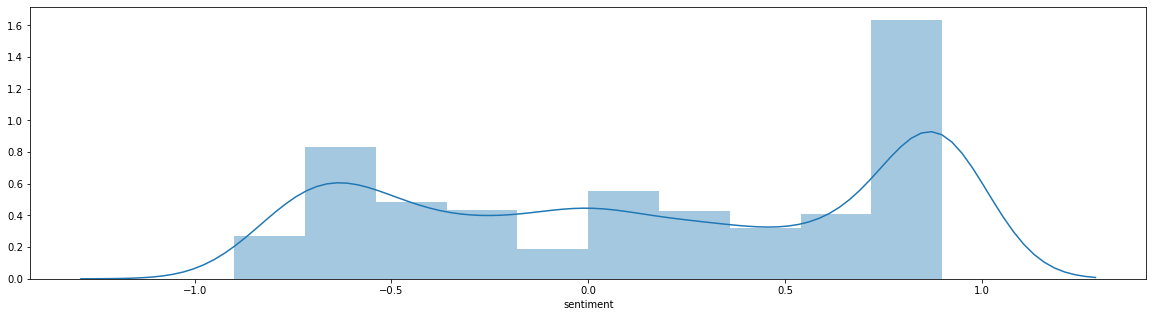

<Figure size 1440x360 with 0 Axes>

In [42]:
vyplotit(dataset,"sentiment")

## Sentiment bins

<AxesSubplot:xlabel='sentiment_cat', ylabel='count'>

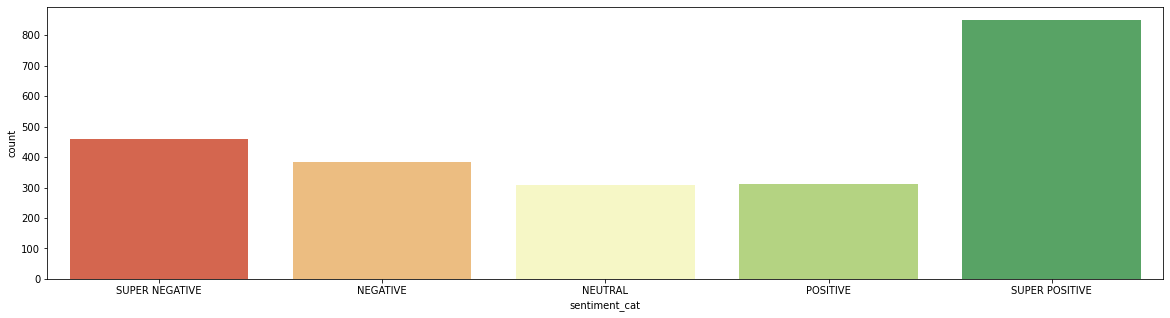

In [43]:
dataset["sentiment_cat"] = pd.cut(dataset["sentiment"], 
                   bins=[-1,-0.6,-0.2,0.2,0.6,1], 
                   labels=["SUPER NEGATIVE","NEGATIVE", "NEUTRAL", "POSITIVE","SUPER POSITIVE"])
sns.countplot(x="sentiment_cat", data=dataset, palette="RdYlGn")

## Sentiment hotelů s nejvíce reviews

In [44]:
dataset_top_hotely = dataset.groupby("Hotel_Name").filter(lambda x: len(x) > 18)
len(dataset_top_hotely)

159

<AxesSubplot:xlabel='Hotel_Name', ylabel='count'>

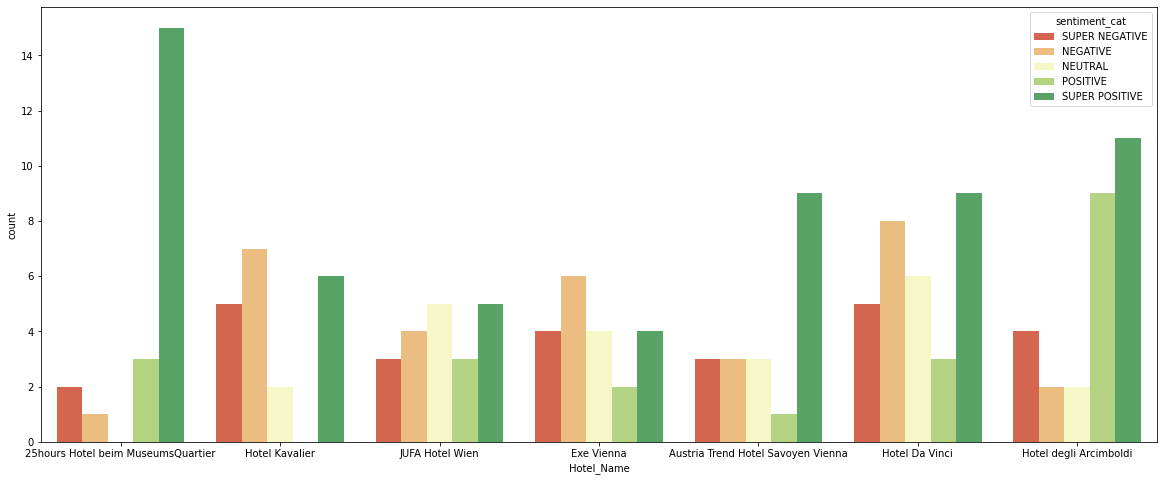

In [45]:
fig = plt.figure(figsize = (20, 8))
sns.countplot(x="Hotel_Name", hue="sentiment_cat", data=dataset_top_hotely, palette="RdYlGn")

## World Clouds - výskyt slov

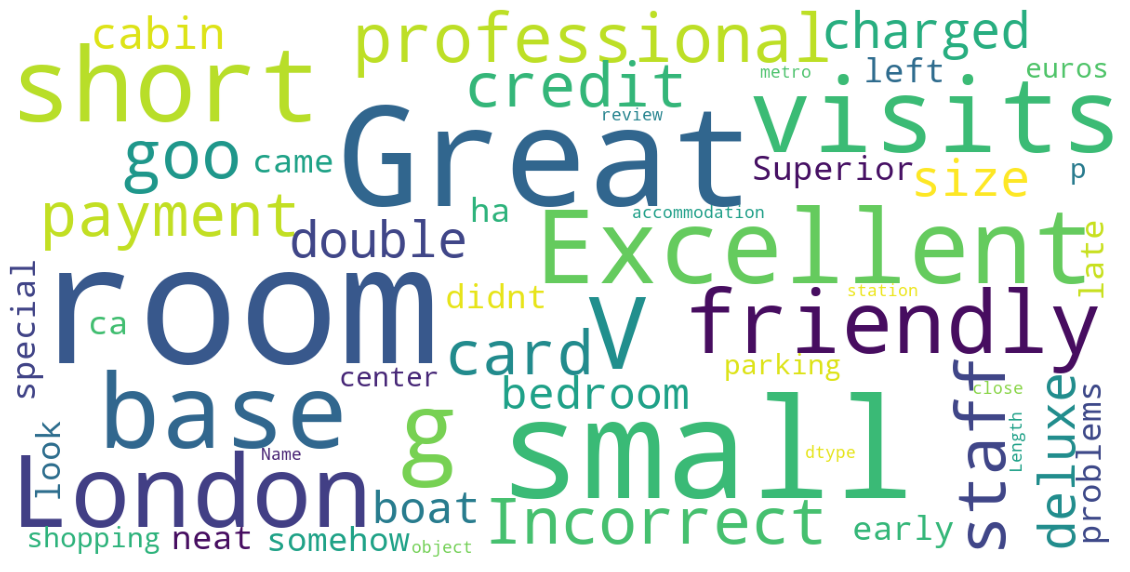

In [46]:
# wordcloud function

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 60, 
        scale = 3,
        random_state = 420
    ).generate(str(data))

    fig = plt.figure(figsize = (20, 20))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(dataset["review"])

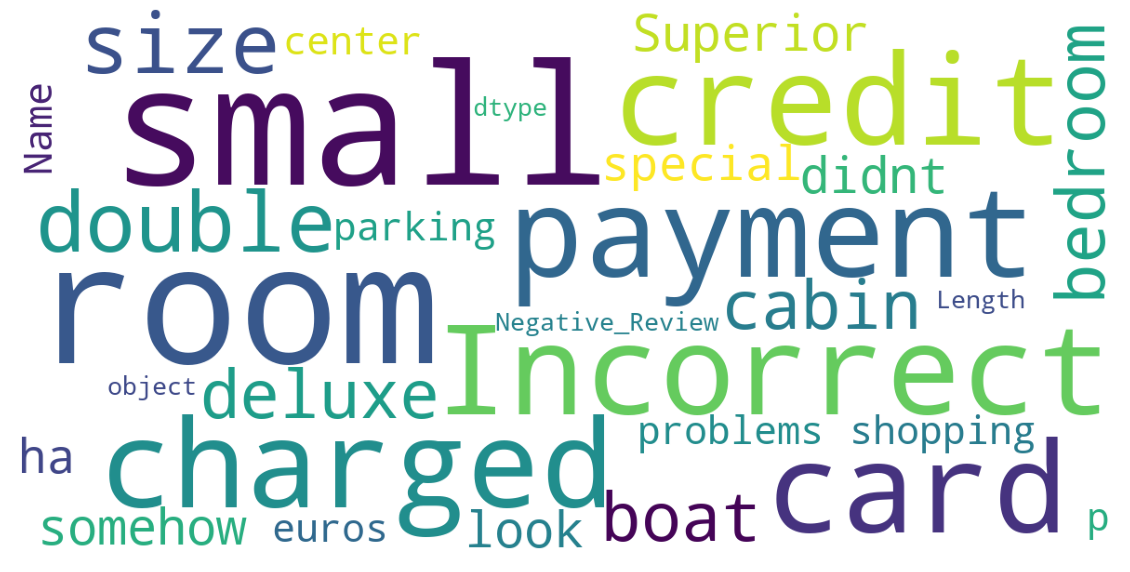

In [47]:
# print negative wordcloud
show_wordcloud(dataset["Negative_Review"])

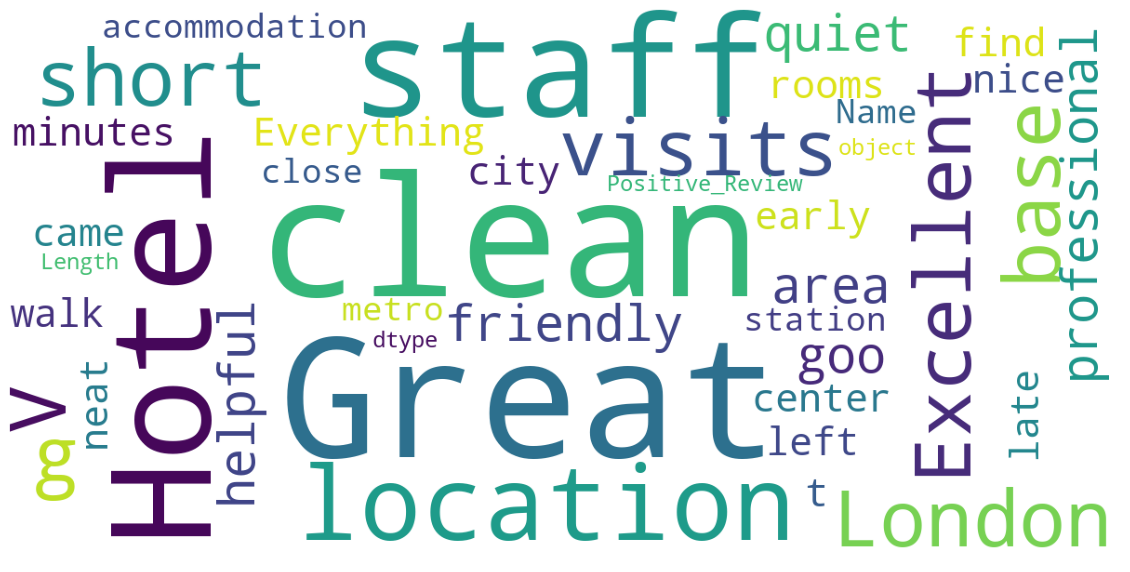

In [48]:
# print positive wordcloud
show_wordcloud(dataset["Positive_Review"])

## Corelation Matrix

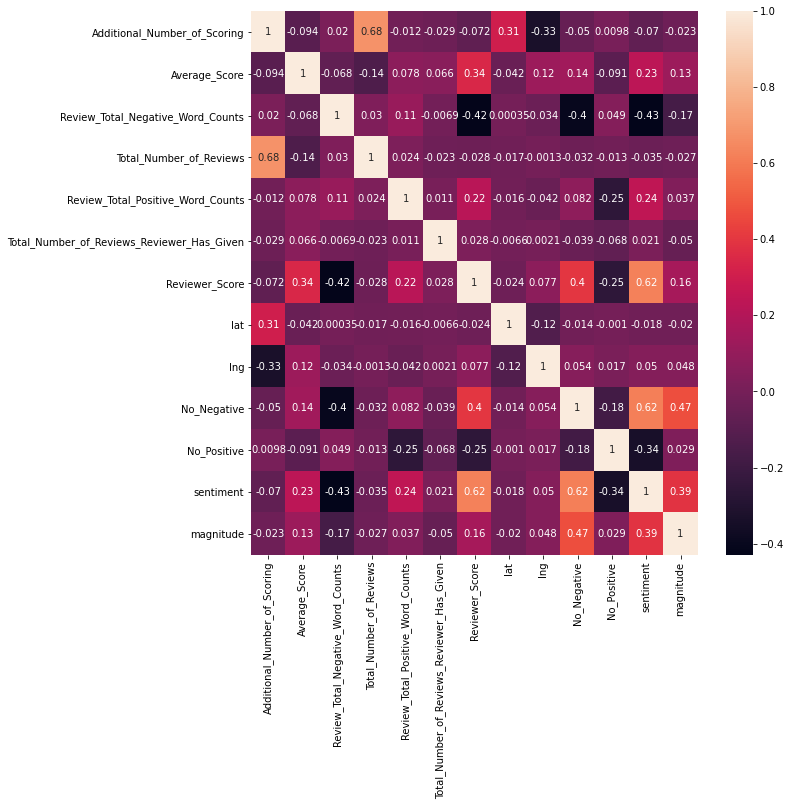

In [49]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
corrMatrix = dataset.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [50]:
# Jak si můžeme povšimnout, námi vytvořený sentiment má silnou pozitivní korelaci s uvedeným "Reviewer_Score"
# Dále je vidět, že celkový počet pozitivních i negativních slov mají oba vliv na "Reviewer_Score" v logickém směru
# Ostatní hodnoty se nezdají mít vysoký vliv na "Reviewer_Score"

## Plot Reviews

<AxesSubplot:xlabel='Reviewer_Score_Rounded', ylabel='count'>

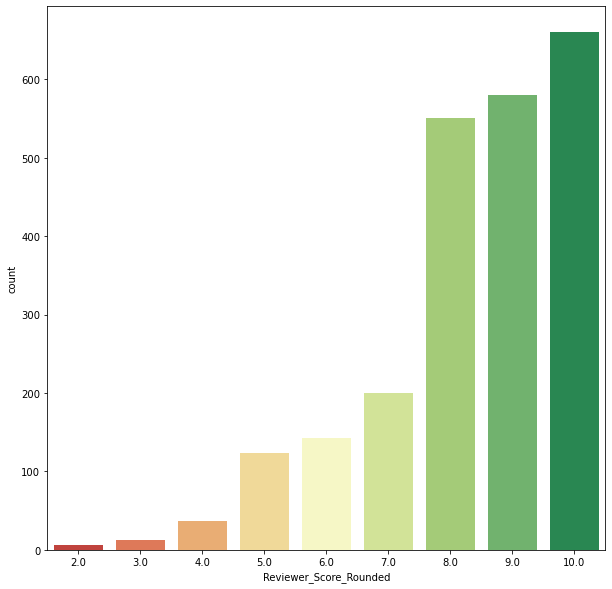

In [51]:
#Round the reviews
dataset['Reviewer_Score_Rounded'] = dataset.Reviewer_Score.round()
#Distribuce Reviewer_Score
sns.countplot(x="Reviewer_Score_Rounded", data=dataset, palette="RdYlGn")

# Tags - Text mining

In [52]:
dataset['Tags'][0].split(",")

["[' Business trip '",
 " ' Solo traveler '",
 " ' Classic Twin Room '",
 " ' Stayed 1 night ']"]

In [53]:
dataset['Tags'] = dataset.Tags.apply(lambda x: x.replace(' ', ""))

In [54]:
dataset['Tags'] = dataset.Tags.apply(lambda x: x.replace("'", ""))

In [55]:
dataset['Tags'] = dataset.Tags.apply(lambda x: x.replace("[", ""))

In [56]:
dataset['Tags'] = dataset.Tags.apply(lambda x: x.replace("]", ""))

In [57]:
dataset['Tags'][0].split(",")

['Businesstrip', 'Solotraveler', 'ClassicTwinRoom', 'Stayed1night']

In [58]:
# Create Tag set
Tags_set = set()
for i in range(len(dataset)):
    Tags_set.update(dataset['Tags'][i].split(","))
    
print(len(Tags_set))

383


In [59]:
Tags_dict = dict.fromkeys(Tags_set, 0)

In [60]:
for i in range(len(dataset)):
    for val in dataset['Tags'][i].split(","):
        Tags_dict[str(val)] += 1

In [61]:
tags_count = Counter(Tags_dict) 

In [62]:
# Tagy, které nám přinášejí nejvíce informace
tags_count.most_common(20)

[('Leisuretrip', 1611),
 ('Couple', 1046),
 ('Submittedfromamobiledevice', 746),
 ('Stayed1night', 741),
 ('Stayed2nights', 736),
 ('Businesstrip', 607),
 ('Solotraveler', 598),
 ('Stayed3nights', 526),
 ('Familywithyoungchildren', 315),
 ('Group', 262),
 ('DoubleRoom', 226),
 ('Stayed4nights', 203),
 ('StandardDoubleRoom', 148),
 ('DoubleorTwinRoom', 143),
 ('SuperiorDoubleRoom', 109),
 ('StandardDoubleorTwinRoom', 97),
 ('SingleRoom', 86),
 ('ClassicDoubleRoom', 83),
 ('Familywitholderchildren', 81),
 ('DeluxeDoubleRoom', 78)]

In [63]:
list_top_tags = list()

In [64]:
for i in range(20):
    list_top_tags += [tags_count.most_common(20)[i][0]]

In [65]:
list_top_tags

['Leisuretrip',
 'Couple',
 'Submittedfromamobiledevice',
 'Stayed1night',
 'Stayed2nights',
 'Businesstrip',
 'Solotraveler',
 'Stayed3nights',
 'Familywithyoungchildren',
 'Group',
 'DoubleRoom',
 'Stayed4nights',
 'StandardDoubleRoom',
 'DoubleorTwinRoom',
 'SuperiorDoubleRoom',
 'StandardDoubleorTwinRoom',
 'SingleRoom',
 'ClassicDoubleRoom',
 'Familywitholderchildren',
 'DeluxeDoubleRoom']

In [66]:
for val in list_top_tags:
    dataset[str(val)] = 0

In [67]:
dataset.head(1)

Hotel_Address  Additional_Number_of_Scoring Review_Date  Average_Score        Hotel_Name Reviewer_Nationality Negative_Review  Review_Total_Negative_Word_Counts  Total_Number_of_Reviews                                    Positive_Review  Review_Total_Positive_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score                                               Tags days_since_review        lat       lng  No_Negative  No_Positive                                             review  sentiment  magnitude   sentiment_cat  Reviewer_Score_Rounded  Leisuretrip  Couple  Submittedfromamobiledevice  Stayed1night  Stayed2nights  Businesstrip  Solotraveler  Stayed3nights  Familywithyoungchildren  Group  DoubleRoom  Stayed4nights  StandardDoubleRoom  DoubleorTwinRoom  SuperiorDoubleRoom  StandardDoubleorTwinRoom  SingleRoom  ClassicDoubleRoom  Familywitholderchildren  DeluxeDoubleRoom
0  1 15 Templeton Place Earl s Court Kensington a...                           244   2/27/2016            8.5  K K Hotel George      Czech Republic                                                   0                     1831   Excellent base for short visits to London V g...                                 25                                           8             9.6  Businesstrip,Solotraveler,ClassicTwinRoom,Stay...           523 day  51.491888 -0.194971            1            0   Excellent base for short visits to London V g...        0.9        0.9  SUPER POSITIVE                    10.0            0       0                           0             0              0             0             0              0                        0      0           0              0                   0                 0                   0                         0           0                  0                        0                 0

In [68]:
for i in range(len(dataset)):
    for val in dataset['Tags'][i].split(","):
        if val in list_top_tags:
            dataset[str(val)][i] = 1

<ipython-input-68-34be9b2784eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[str(val)][i] = 1


# Doporučení pro různé klienty

## Couples

In [69]:
dataset_couple = dataset[dataset['Couple'] == 1].copy()
dataset_couple = dataset_couple.groupby("Hotel_Name").filter(lambda x: len(x) >= 8)

In [70]:
pd.pivot_table(dataset_couple, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score     sentiment
Hotel_Name                                                                               
25hours Hotel beim MuseumsQuartier                       14        8.971429  4.071429e-01
Austria Trend Hotel Park Royal Palace Vienna              9        8.755556  4.111111e-01
Austria Trend Hotel Savoyen Vienna                        9        9.311111  2.111111e-01
Best Western Premier Hotel Couture                        8        9.550000  7.000000e-01
Best Western Premier Kaiserhof Wien                       9        9.644444  8.555555e-01
Exe Vienna                                               13        7.384615 -1.146243e-09
Fleming s Selection Hotel Wien City                       8        8.150000  2.750000e-01
Hotel Da Vinci                                           18        8.244444  1.666667e-01
Hotel Das Tigra                                           8        8.825000  4.875000e-01
Hotel Kavalier                                           11        8.609091  1.909091e-01
Hotel degli Arcimboldi                                   21        8.890476  3.333333e-01
JUFA Hotel Wien                                           8        8.550000  2.000000e-01
Melia Vienna                                             10        8.690000  3.000000e-01
All                                                     146        8.686986  3.246575e-01

In [ ]:
#Podle výsledků doporučujeme Best Western Premier Kaiserhof Wien

## Solo

In [71]:
dataset_solo = dataset[dataset['Solotraveler'] == 1].copy()
dataset_solo = dataset_solo.groupby("Hotel_Name").filter(lambda x: len(x) > 4)

In [72]:
pd.pivot_table(dataset_solo, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score  sentiment
Hotel_Name                                                                  
Austria Trend Hotel Ananas Wien                 5        7.080000  -0.520000
Austria Trend Hotel Doppio Wien                 5        7.180000   0.000000
Austria Trend Hotel Savoyen Vienna              5        8.600000   0.240000
Holiday Inn London Kensington                   6        7.300000  -0.433333
Hotel Erzherzog Rainer                          6        8.966667   0.416667
Hotel Prinz Eugen                               5        7.120000  -0.060000
Hotel Regina                                   10        8.430000   0.270000
Hotel Schani Wien                               6        8.000000  -0.033333
JUFA Hotel Wien                                 5        7.600000  -0.220000
The Piccadilly London West End                  5        9.280000   0.520000
citizenM Tower of London                        5        9.420000   0.560000
All                                            63        8.115873   0.079365

In [ ]:
#Podle výsledků doporučujeme citizenM Tower of London

## Family with young children

In [73]:
dataset_family = dataset[dataset['Familywithyoungchildren'] == 1].copy()
dataset_family = dataset_family.groupby("Hotel_Name").filter(lambda x: len(x) > 4)

In [74]:
pd.pivot_table(dataset_family, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score  sentiment
Hotel_Name                                                                       
Arion Cityhotel Vienna und Appartements              9        7.877778  -0.088889
Austria Trend Hotel Savoyen Vienna                   5        9.360000   0.440000
BEST WESTERN PLUS Amedia Wien                        5        8.000000   0.040000
Capri by Fraser Barcelona                            5        8.260000   0.280000
All                                                 24        8.291667   0.125000

In [ ]:
#Podle výsledků doporučujeme Austria Trend Hotel Savoyen Vienna	

## Family with older children

In [121]:
dataset_family_old = dataset[dataset['Familywitholderchildren'] == 1].copy()
dataset_family_old = dataset_family_old.groupby("Hotel_Name").filter(lambda x: len(x) > 1)

In [122]:
pd.pivot_table(dataset_family_old, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score  sentiment
Hotel_Name                                                                         
Austria Trend Hotel Astoria Wien                       2        6.700000   0.200000
Austria Trend Hotel Bosei Wien                         2        9.200000   0.900000
Courtyard by Marriott Vienna Prater Messe              2        8.750000   0.600000
Hilton London Metropole                                2        5.600000  -0.650000
Holiday Inn London Kensington                          2        7.100000  -0.750000
Holiday Inn London Mayfair                             2        8.150000   0.050000
JUFA Hotel Wien                                        3        9.466667  -0.100000
Park Plaza Victoria London                             2        8.350000  -0.500000
The Nadler Soho                                        2        9.400000   0.500000
The Student Hotel Amsterdam City                       2        7.700000   0.000000
All                                                   21        8.109524   0.019048

In [ ]:
#Podle výsledků doporučujeme The Nadler Soho

## Group

In [77]:
dataset_group = dataset[dataset['Group'] == 1].copy()
dataset_group = dataset_group.groupby("Hotel_Name").filter(lambda x: len(x) > 2)

In [78]:
pd.pivot_table(dataset_group, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score     sentiment
Hotel_Name                                                                               
Austria Trend Hotel Ananas Wien                           3        6.566667 -3.000000e-01
Austria Trend Hotel Astoria Wien                          3        9.200000  8.666667e-01
Austria Trend Hotel Park Royal Palace Vienna              3        7.366667  7.450581e-09
Barcelona Princess                                        3        8.900000  0.000000e+00
Der Wilhelmshof                                           3        9.033333  7.666667e-01
Hotel Atlanta                                             3        7.933333 -1.000000e-01
Hotel Da Vinci                                            5        8.760000  4.000000e-01
Hotel degli Arcimboldi                                    3        8.766667  1.666667e-01
Idea Hotel Milano San Siro                                3        5.833333 -9.999999e-02
JUFA Hotel Wien                                           3        9.033333  3.333334e-02
Le Meridien Vienna                                        3        8.600000  4.333333e-01
Ramada Apollo Amsterdam Centre                            3        7.233333 -2.000000e-01
Uptown Palace                                             3        8.200000  2.666667e-01
Urban Lodge Hotel                                         3        9.466667  2.333333e-01
All                                                      44        8.231818  1.863636e-01

In [ ]:
#Podle výsledků doporučujeme Austria Trend Hotel Astoria Wien

## Business trip

In [79]:
dataset_business = dataset[dataset['Businesstrip'] == 1].copy()
dataset_business = dataset_business.groupby("Hotel_Name").filter(lambda x: len(x) > 5)

In [80]:
pd.pivot_table(dataset_business, 
               values=["sentiment", "Reviewer_Score","Hotel_Address"], 
               aggfunc={"sentiment":"mean", "Reviewer_Score":"mean","Hotel_Address":"count"}, 
               index=["Hotel_Name"],
               margins=True)

Hotel_Address  Reviewer_Score  sentiment
Hotel_Name                                                                          
Austria Trend Hotel Ananas Wien                         6        6.466667  -0.566667
Austria Trend Hotel Astoria Wien                        6        8.416667  -0.016667
Austria Trend Hotel Bosei Wien                          6        8.283333  -0.050000
Barcelona Princess                                      6        8.216667  -0.066667
Britannia International Hotel Canary Wharf              6        5.716667  -0.250000
Holiday Inn London Kensington                           6        7.716667  -0.183333
Hotel Regina                                            8        8.287500   0.237500
JUFA Hotel Wien                                         7        8.171429  -0.042857
The Piccadilly London West End                          6        9.266667   0.516667
citizenM Tower of London                                6        8.833333   0.383333
All                                                    63        7.952381   0.003175

In [ ]:
#Podle výsledků doporučujeme The Piccadilly London West End

# Spacy

In [81]:
#Využijeme Spacy pro vytvoření tokenů, které jsou nejčastější Přídavná jména

In [82]:
nlp = spacy.load("en_core_web_md")

In [83]:
text = nlp(dataset['review'][0])

In [84]:
[token.lemma_ for token in text if token.pos_ == "ADJ"]

['excellent', 'short', 'good', 'charming', 'maintained', 'small']

In [85]:
# Create ADJ set
ADJ_set = set()
for i in range(len(dataset)):
    text = nlp(dataset['review'][i])
    ADJ_set.update([token.lemma_ for token in text if token.pos_ == "ADJ"])
    
print(len(ADJ_set))

883


In [86]:
ADJ_dict = dict.fromkeys(ADJ_set, 0)

In [87]:
for i in range(len(dataset)):
    text = nlp(dataset['review'][i])
    for val in [token.lemma_ for token in text if token.pos_ == "ADJ"]:
        ADJ_dict[str(val)] += 1

In [88]:
ADJ_count = Counter(ADJ_dict)

In [89]:
ADJ_count.most_common(40)

[('good', 746),
 ('nice', 650),
 ('great', 493),
 ('clean', 366),
 ('small', 326),
 ('friendly', 301),
 ('comfortable', 284),
 ('helpful', 241),
 ('perfect', 212),
 ('excellent', 205),
 ('big', 158),
 ('free', 139),
 ('close', 129),
 ('noisy', 128),
 ('quiet', 116),
 ('old', 103),
 ('little', 89),
 ('poor', 88),
 ('expensive', 87),
 ('modern', 85),
 ('bad', 84),
 ('amazing', 76),
 ('large', 75),
 ('more', 75),
 ('spacious', 73),
 ('well', 66),
 ('cold', 65),
 ('other', 65),
 ('many', 62),
 ('high', 57),
 ('new', 56),
 ('few', 54),
 ('beautiful', 54),
 ('extra', 54),
 ('hot', 53),
 ('public', 52),
 ('kind', 51),
 ('main', 50),
 ('easy', 49),
 ('first', 49)]

In [90]:
list_top_ADJ = list()
for i in range(40):
    list_top_ADJ += [ADJ_count.most_common(40)[i][0]]

In [91]:
list_top_ADJ

['good',
 'nice',
 'great',
 'clean',
 'small',
 'friendly',
 'comfortable',
 'helpful',
 'perfect',
 'excellent',
 'big',
 'free',
 'close',
 'noisy',
 'quiet',
 'old',
 'little',
 'poor',
 'expensive',
 'modern',
 'bad',
 'amazing',
 'large',
 'more',
 'spacious',
 'well',
 'cold',
 'other',
 'many',
 'high',
 'new',
 'few',
 'beautiful',
 'extra',
 'hot',
 'public',
 'kind',
 'main',
 'easy',
 'first']

In [92]:
# Vytvoření sloupců
for val in list_top_ADJ:
    dataset[str(val)] = 0

In [93]:
for i in range(len(dataset)):
    text = nlp(dataset['review'][i])
    for val in [token.lemma_ for token in text if token.pos_ == "ADJ"]:
        if val in list_top_ADJ:
            dataset[str(val)][i] = 1

<ipython-input-93-6404e42e53f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[str(val)][i] = 1


In [94]:
dataset.head(1)

Hotel_Address  Additional_Number_of_Scoring Review_Date  Average_Score        Hotel_Name Reviewer_Nationality Negative_Review  Review_Total_Negative_Word_Counts  Total_Number_of_Reviews                                    Positive_Review  Review_Total_Positive_Word_Counts  Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score                                               Tags days_since_review        lat       lng  No_Negative  No_Positive                                             review  sentiment  magnitude   sentiment_cat  Reviewer_Score_Rounded  Leisuretrip  Couple  Submittedfromamobiledevice  Stayed1night  Stayed2nights  Businesstrip  Solotraveler  Stayed3nights  Familywithyoungchildren  Group  DoubleRoom  Stayed4nights  StandardDoubleRoom  DoubleorTwinRoom  SuperiorDoubleRoom  StandardDoubleorTwinRoom  SingleRoom  ClassicDoubleRoom  Familywitholderchildren  DeluxeDoubleRoom  good  nice  great  clean  small  friendly  comfortable  \
0  1 15 Templeton Place Earl s Court Kensington a...                           244   2/27/2016            8.5  K K Hotel George      Czech Republic                                                   0                     1831   Excellent base for short visits to London V g...                                 25                                           8             9.6  Businesstrip,Solotraveler,ClassicTwinRoom,Stay...           523 day  51.491888 -0.194971            1            0   Excellent base for short visits to London V g...        0.9        0.9  SUPER POSITIVE                    10.0            0       0                           0             1              0             1             1              0                        0      0           0              0                   0                 0                   0                         0           0                  0                        0                 0     1     0      0      0      1         0            0   

   helpful  perfect  excellent  big  free  close  noisy  quiet  old  little  poor  expensive  modern  bad  amazing  large  more  spacious  well  cold  other  many  high  new  few  beautiful  extra  hot  public  kind  main  easy  first  
0        0        0          1    0     0      0      0      0    0       0     0          0       0    0        0      0     0         0     0     0      0     0     0    0    0          0      0    0       0     0     0     0      0

# Predikce Reviewer_Score na základě textu

In [95]:
dataset_pred = dataset.copy()

In [96]:
# DELETE nepouzitych sloupců
del dataset_pred['Hotel_Address'], dataset_pred['Additional_Number_of_Scoring'], dataset_pred['Review_Date']
del dataset_pred['Average_Score'], dataset_pred['Hotel_Name'], dataset_pred['Reviewer_Nationality']
del dataset_pred['Negative_Review'], dataset_pred['Total_Number_of_Reviews'], dataset_pred['Positive_Review']
del dataset_pred['Total_Number_of_Reviews_Reviewer_Has_Given'], dataset_pred['Tags'], dataset_pred['days_since_review']
del dataset_pred['review'], dataset_pred['lat'], dataset_pred['lng'], dataset_pred['sentiment_cat']
del dataset_pred['Reviewer_Score_Rounded']

In [97]:
dataset_pred.head(1)

Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  Reviewer_Score  No_Negative  No_Positive  sentiment  magnitude  Leisuretrip  Couple  Submittedfromamobiledevice  Stayed1night  Stayed2nights  Businesstrip  Solotraveler  Stayed3nights  Familywithyoungchildren  Group  DoubleRoom  Stayed4nights  StandardDoubleRoom  DoubleorTwinRoom  SuperiorDoubleRoom  StandardDoubleorTwinRoom  SingleRoom  ClassicDoubleRoom  Familywitholderchildren  DeluxeDoubleRoom  good  nice  great  clean  small  friendly  comfortable  helpful  perfect  excellent  big  free  close  noisy  quiet  old  little  poor  expensive  modern  bad  amazing  large  more  spacious  well  cold  other  many  high  new  few  beautiful  extra  hot  public  kind  main  easy  first
0                                  0                                 25             9.6            1            0        0.9        0.9            0       0                           0             1              0             1             1              0                        0      0           0              0                   0                 0                   0                         0           0                  0                        0                 0     1     0      0      0      1         0            0        0        0          1    0     0      0      0      0    0       0     0          0       0    0        0      0     0         0     0     0      0     0     0    0    0          0      0    0       0     0     0     0      0

## Train test split

In [98]:
X = dataset_pred.drop(['Reviewer_Score'], axis=1)
y = dataset_pred['Reviewer_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [99]:
X.head(1)

Review_Total_Negative_Word_Counts  Review_Total_Positive_Word_Counts  No_Negative  No_Positive  sentiment  magnitude  Leisuretrip  Couple  Submittedfromamobiledevice  Stayed1night  Stayed2nights  Businesstrip  Solotraveler  Stayed3nights  Familywithyoungchildren  Group  DoubleRoom  Stayed4nights  StandardDoubleRoom  DoubleorTwinRoom  SuperiorDoubleRoom  StandardDoubleorTwinRoom  SingleRoom  ClassicDoubleRoom  Familywitholderchildren  DeluxeDoubleRoom  good  nice  great  clean  small  friendly  comfortable  helpful  perfect  excellent  big  free  close  noisy  quiet  old  little  poor  expensive  modern  bad  amazing  large  more  spacious  well  cold  other  many  high  new  few  beautiful  extra  hot  public  kind  main  easy  first
0                                  0                                 25            1            0        0.9        0.9            0       0                           0             1              0             1             1              0                        0      0           0              0                   0                 0                   0                         0           0                  0                        0                 0     1     0      0      0      1         0            0        0        0          1    0     0      0      0      0    0       0     0          0       0    0        0      0     0         0     0     0      0     0     0    0    0          0      0    0       0     0     0     0      0

## Extreme gradient boosting model (XGboost)

In [100]:
model_XGB = XGBRegressor(n_estimators=20000,learning_rate=0.1)

model_XGB.fit(X_train, y_train, verbose=100,early_stopping_rounds=25,eval_set=[(X_train, y_train)])
predictions = model_XGB.predict(X_test)

[0]	validation_0-rmse:7.18481
Will train until validation_0-rmse hasn't improved in 25 rounds.
[100]	validation_0-rmse:0.66812
[200]	validation_0-rmse:0.48508
[300]	validation_0-rmse:0.38862
[400]	validation_0-rmse:0.30239
[500]	validation_0-rmse:0.24297
[600]	validation_0-rmse:0.19280
[700]	validation_0-rmse:0.15626
[800]	validation_0-rmse:0.12960
[900]	validation_0-rmse:0.10439
[1000]	validation_0-rmse:0.08703
[1100]	validation_0-rmse:0.07258
[1200]	validation_0-rmse:0.06384
[1300]	validation_0-rmse:0.05527
[1400]	validation_0-rmse:0.04905
[1500]	validation_0-rmse:0.04332
[1600]	validation_0-rmse:0.03946
[1700]	validation_0-rmse:0.03496
[1800]	validation_0-rmse:0.03178
[1900]	validation_0-rmse:0.02992
[2000]	validation_0-rmse:0.02737
[2100]	validation_0-rmse:0.02549
[2200]	validation_0-rmse:0.02439
[2300]	validation_0-rmse:0.02339
[2400]	validation_0-rmse:0.02242
[2500]	validation_0-rmse:0.02143
[2600]	validation_0-rmse:0.02068
[2700]	validation_0-rmse:0.02007
[2800]	validation_0-rms

In [101]:
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))
print('XGB Regression: R^2 score on test set', model_XGB.score(X_test, y_test)*100)
print('XGB Regression: R^2 ADJUSTED score on test set', (1 - (1-model_XGB.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))*100)

Mean Absolute Error : 0.9167407289179561
XGB Regression: R^2 score on test set 44.80328729895924
XGB Regression: R^2 ADJUSTED score on test set 35.60383518211911


### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

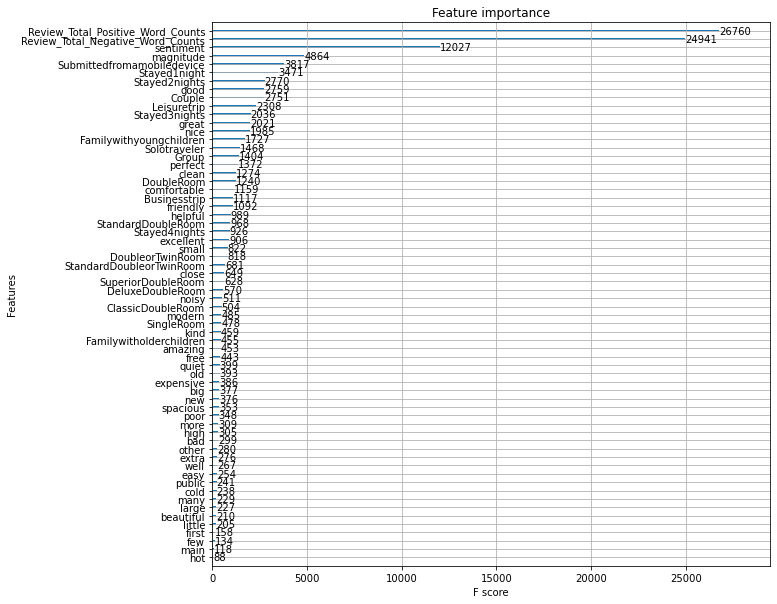

In [102]:
plot_importance(model_XGB)

## Model LASSO - regularizovaný lineární model

In [103]:
model_lasso = LassoCV(normalize=True).fit(X_train, y_train)
lasso_prediction = model_lasso.predict(X_test)

In [104]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [105]:
print("Mean Absolute Error : " + str(mean_absolute_error(lasso_prediction, y_test)))
print('Lasso Regression: R^2 score on training set', model_lasso.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', model_lasso.score(X_test, y_test)*100)
print('Lasso Regression: R^2 ADJUSTED score on test set', (1 - (1-model_lasso.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1+int(sum(coef == 0))))*100)

Mean Absolute Error : 0.8734524705176581
Lasso Regression: R^2 score on training set 48.030624614521024
Lasso Regression: R^2 score on test set 46.61825053418936
Lasso Regression: R^2 ADJUSTED score on test set 43.04302943832674


In [106]:
imp_coef = pd.concat([coef.sort_values().head(round(sum(coef !=0)/2)),
                      coef.sort_values().tail(round(sum(coef !=0)/2))])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

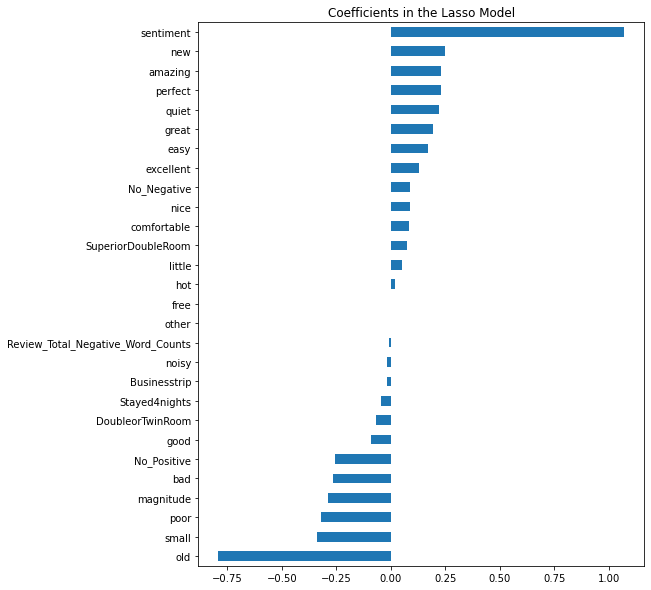

In [107]:
plt.rcParams['figure.figsize'] = (8.0, 10)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Transformace dat - normalizace target variable

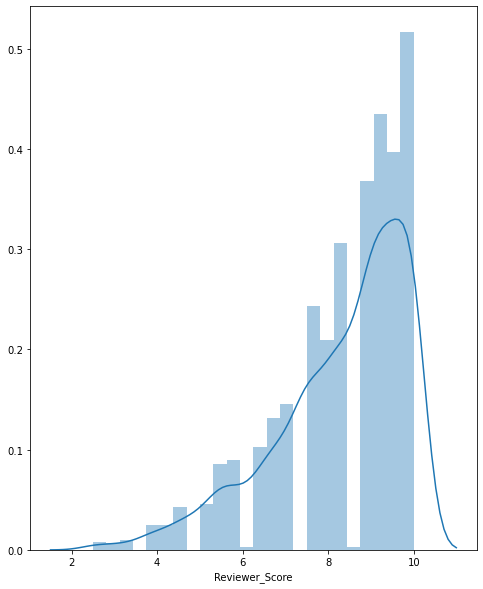

<Figure size 576x720 with 0 Axes>

In [108]:
vyplotit(dataset_pred,'Reviewer_Score')

In [109]:
dataset_pred['Reviewer_Score'],fitted_lambda_plocha = stats.boxcox(dataset_pred['Reviewer_Score'])

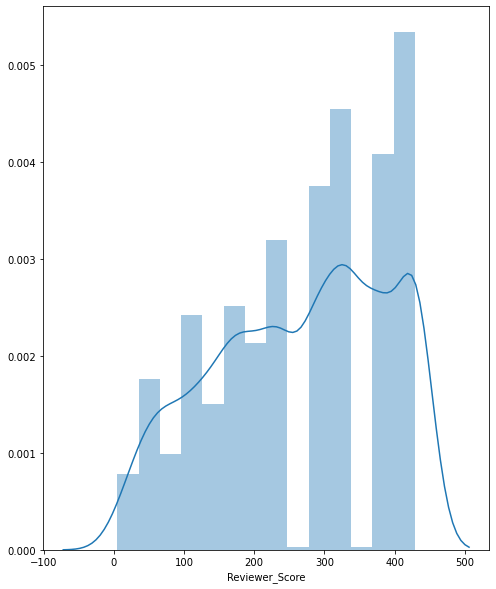

<Figure size 576x720 with 0 Axes>

In [110]:
vyplotit(dataset_pred,'Reviewer_Score')

In [111]:
X = dataset_pred.drop(['Reviewer_Score'], axis=1)
y = dataset_pred['Reviewer_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [112]:
model_lasso = LassoCV(normalize=True).fit(X_train, y_train)
lasso_prediction = model_lasso.predict(X_test)

In [113]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [114]:
print("Mean Absolute Error : " + str(mean_absolute_error(inv_boxcox(lasso_prediction,fitted_lambda_plocha), inv_boxcox(y_test,fitted_lambda_plocha))))
print('Lasso Regression: R^2 score on training set', model_lasso.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', model_lasso.score(X_test, y_test)*100)
print('Lasso Regression: R^2 ADJUSTED score on test set', (1 - (1-model_lasso.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1+int(sum(coef == 0))))*100)

Mean Absolute Error : 0.883518708557798
Lasso Regression: R^2 score on training set 48.09335851581289
Lasso Regression: R^2 score on test set 48.254671910890934
Lasso Regression: R^2 ADJUSTED score on test set 44.53285016898286


In [115]:
#Transformace nebyla úspěšná na metrice MAE

In [116]:
(len(y_test)-1)

462

In [117]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 31 variables and eliminated the other 35 variables


In [118]:
imp_coef = pd.concat([coef.sort_values().head(round(sum(coef !=0)/2)),
                      coef.sort_values().tail(round(sum(coef !=0)/2))])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

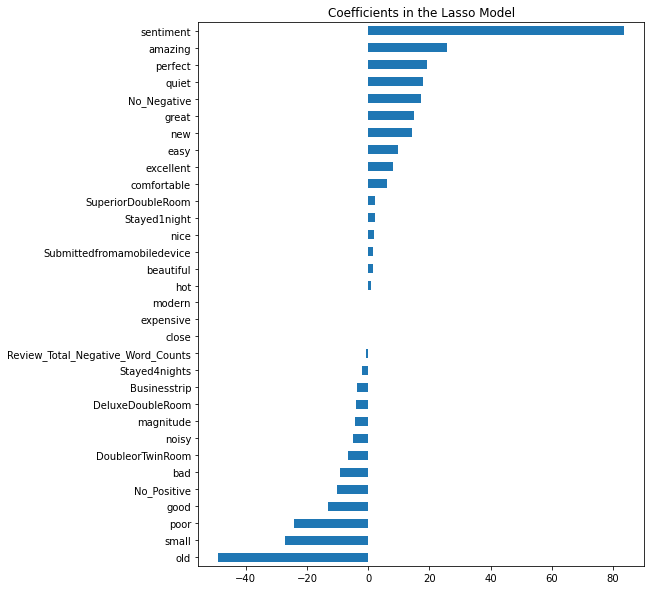

In [119]:
plt.rcParams['figure.figsize'] = (8.0, 10)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# COPYRIGHT

In [120]:
# © Vojtěch Staš
# Pro nabídky práce mě neváhejte kontaktovat na emailu: vojtechstas@gmail.com nebo stav06@vse.cz